In [0]:
#Import dependencies
import cv2
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from matplotlib import pyplot as plt
import imghdr
from pyspark.sql.types import ArrayType, IntegerType

import mlflow
import mlflow
import mlflow.keras
from mlflow.tracking.client import MlflowClient
import mlflow.pyfunc



In [0]:
#Set Spark conf to access ADLS
spark.conf.set(f"fs.azure.account.auth.type.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", f"{dbutils.secrets.get('storageaccount', 'sastoken')}")

In [0]:
#Read image from ADLS as Spark DF
df = spark.read.format("image").load(f"abfss://nga-ml@{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net/clean_room/clean_room_2.jpg")

In [0]:
#Show image metadata
df.select("image.height", "image.width"
         ,"image.nChannels", "image.mode"
         ,"image.data").show()

+------+-----+---------+----+--------------------+
|height|width|nChannels|mode|                data|
+------+-----+---------+----+--------------------+
|  1000|  667|        3|  16|[7B 7C 8A 7A 7B 8...|
+------+-----+---------+----+--------------------+



In [0]:
#Convert bytearray to numpy ndarray
img_array = np.array(df.select('image.data').collect()[0]['data'])

#Reshape numpy.ndarray to height x width x channels
img_array = img_array.reshape((1000, 667, 3))

#Check shape
img_array.shape

Out[5]: (1000, 667, 3)

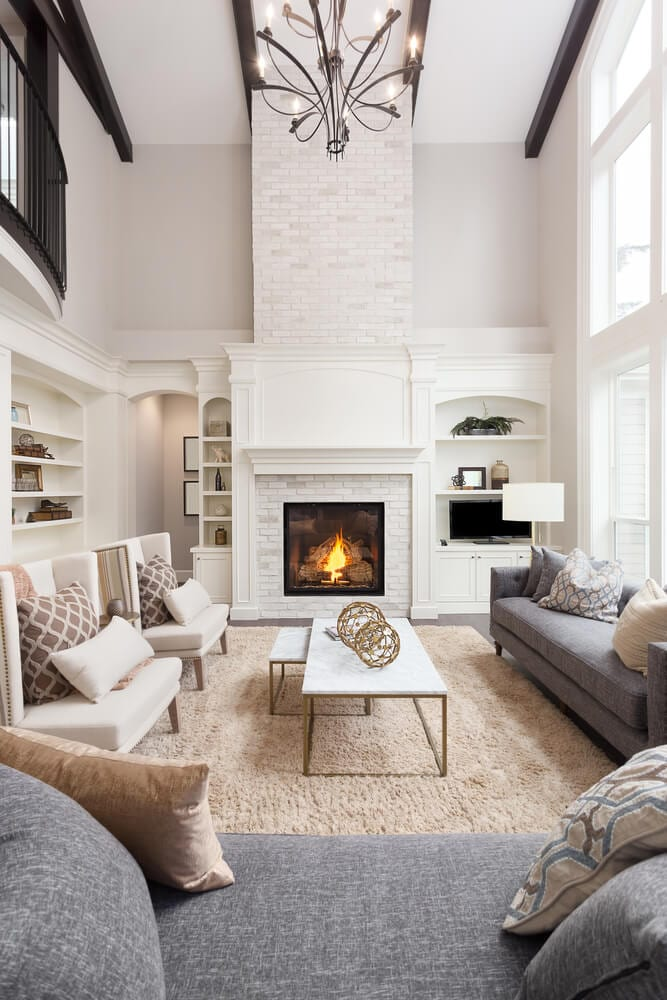

In [0]:
#View image
from dbruntime.patches import cv2_imshow
cv2_imshow(img_array)

In [0]:
#Mount ADLS
config = {"fs.azure.account.key.teststorageaccount1171.blob.core.windows.net":f"{dbutils.secrets.get('storageaccount', 'container-accesskeys')}"}

dbutils.fs.mount(
  source = "wasbs://nga-ml@teststorageaccount1171.blob.core.windows.net",
  mount_point = "/mnt/nga-ml",
  extra_configs = config)

In [0]:
# Clean images by removing any corrupt images
data_dir = "/dbfs/mnt/nga-ml"
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

In [0]:
# Load image datasets using TF
data = tf.keras.utils.image_dataset_from_directory("/dbfs/mnt/nga-ml")

Found 516 files belonging to 2 classes.


In [0]:
# Create iterator
data_iterator = data.as_numpy_iterator()

In [0]:
batch = data_iterator.next()

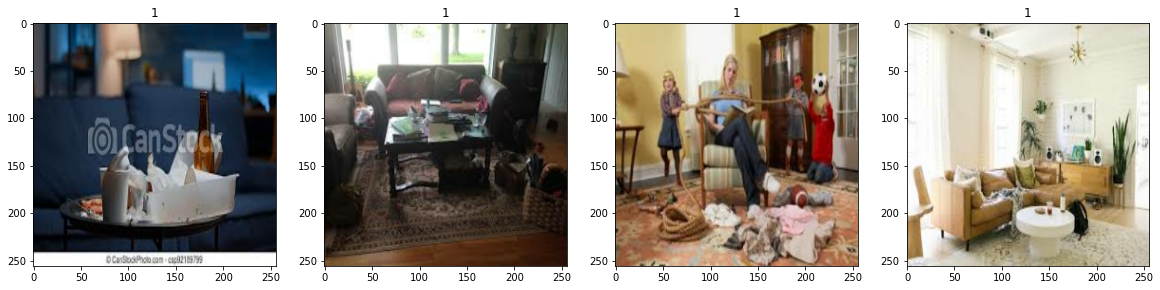

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [0]:
# Scale data
data = data.map(lambda x, y: (x/255, y))

In [0]:
scaled_iterator = data.as_numpy_iterator()

In [0]:
batch = scaled_iterator.next()

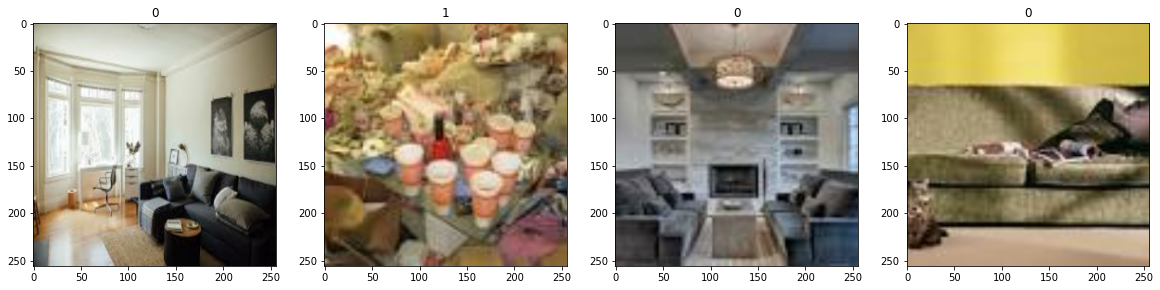

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


In [0]:
# Split data
train_size = int(len(data) * 0.7) + 1
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)

In [0]:
 train_size + val_size + test_size == len(data)

Out[34]: True

In [0]:
# Partition data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [0]:
# Build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [0]:
model = Sequential()

In [0]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [0]:
# # Setup logging
# logdir = "/dbfs/mnt/logs"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
#Epochs to be 20
hist = model.fit(train, epochs=20, validation_data=val)


Epoch 1/20
12/12 [==============================] - 59s 4s/step - loss: 0.9135 - accuracy: 0.6615 - val_loss: 0.6739 - val_accuracy: 0.6250
Epoch 2/20
12/12 [==============================] - 59s 4s/step - loss: 0.6459 - accuracy: 0.6823 - val_loss: 0.6098 - val_accuracy: 0.7109
Epoch 3/20
12/12 [==============================] - 56s 4s/step - loss: 0.6325 - accuracy: 0.6823 - val_loss: 0.6164 - val_accuracy: 0.6719
Epoch 4/20
12/12 [==============================] - 56s 4s/step - loss: 0.5718 - accuracy: 0.6823 - val_loss: 0.4776 - val_accuracy: 0.7266
Epoch 5/20
12/12 [==============================] - 60s 4s/step - loss: 0.5219 - accuracy: 0.7292 - val_loss: 0.4847 - val_accuracy: 0.6875
Epoch 6/20
12/12 [==============================] - 55s 4s/step - loss: 0.4449 - accuracy: 0.7995 - val_loss: 0.3832 - val_accuracy: 0.8047
Epoch 7/20
12/12 [==============================] - 55s 4s/step - loss: 0.4209 - accuracy: 0.8281 - val_loss: 0.3442 - val_accuracy: 0.8359
Epoch 8/20
12/12 [==

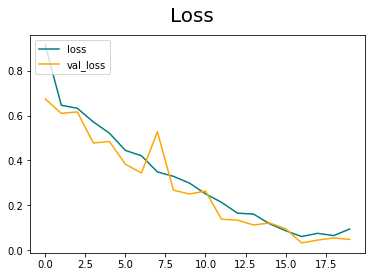

In [0]:
# Plot performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

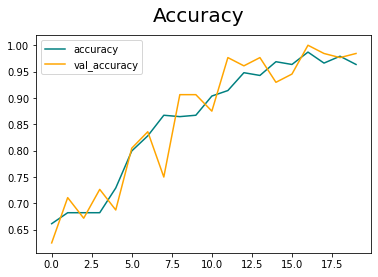

In [0]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [0]:
# Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [0]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [0]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 143ms/step


In [0]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


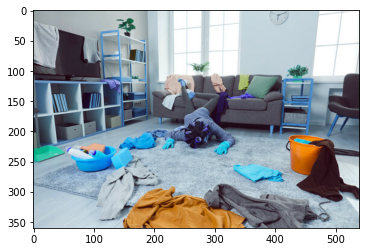

In [0]:
# Test
img = cv2.imread("/dbfs/mnt/nga-ml/dirty_living.jpg")
plt.imshow(img)
plt.show()

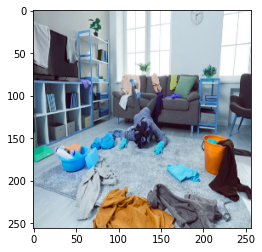

In [0]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [0]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 32ms/step


In [0]:
yhat

Out[34]: array([[0.9562646]], dtype=float32)

In [0]:
if yhat > 0.5:
    print("Predicted class is Messy")
else:
    print("Predicted class is Clean")

Predicted class is Messy


(360, 540, 3)


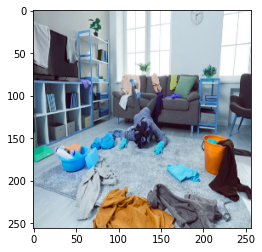

In [0]:
# Test - processing new image being streamed as string array
# Image will be published to Kafka topic as a string array
# Image will need to be consumed and converted back to array to use ML serving API

img = cv2.imread("/dbfs/mnt/nga-ml/dirty_living.jpg")

# Convert to str
msg = str(img)

# Flatten
msg_flat = img.flatten()
msg_flat.shape

# Convert to bytes
msg_bytes = msg_flat.tobytes()

# Convert bytes to array
msg_back_to_array = np.array(list(msg_bytes))

# New reshaped array should be same as original img
print(img.shape)
msg_back_to_array = msg_back_to_array.reshape((360, 540, 3))

# Resize and display
resize = tf.image.resize(msg_back_to_array, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Use ML model to predict
yhat = model.predict(np.expand_dims(resize/255, 0))

In [0]:
# MlFlow Model Registry

# ML model func
def train_keras_model(train, val):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D())

    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(16, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

    model.fit(train, epochs=20, validation_data=val)

    return model


In [0]:
# Train model on MLFlow
with mlflow.start_run():
    mlflow.keras.autolog()

    train_keras_model(train=train, val=val)
    run_id = mlflow.active_run().info.run_id

Epoch 1/20
12/12 [==============================] - 57s 3s/step - loss: 0.7338 - accuracy: 0.6771 - val_loss: 0.6264 - val_accuracy: 0.6484
Epoch 2/20
12/12 [==============================] - 53s 4s/step - loss: 0.5656 - accuracy: 0.6875 - val_loss: 0.5730 - val_accuracy: 0.6328
Epoch 3/20
12/12 [==============================] - 52s 3s/step - loss: 0.4615 - accuracy: 0.7031 - val_loss: 0.4701 - val_accuracy: 0.8281
Epoch 4/20
12/12 [==============================] - 51s 3s/step - loss: 0.3802 - accuracy: 0.8698 - val_loss: 0.3145 - val_accuracy: 0.8828
Epoch 5/20
12/12 [==============================] - 50s 3s/step - loss: 0.3218 - accuracy: 0.8568 - val_loss: 0.2559 - val_accuracy: 0.9141
Epoch 6/20
12/12 [==============================] - 50s 3s/step - loss: 0.2146 - accuracy: 0.9219 - val_loss: 0.1686 - val_accuracy: 0.9531
Epoch 7/20
12/12 [==============================] - 50s 3s/step - loss: 0.2325 - accuracy: 0.8958 - val_loss: 0.2477 - val_accuracy: 0.8906
Epoch 8/20
12/12 [==

In [0]:
# Register model
model_name = "nga-ml"

artifact_path = "model"
model_uri = f"runs:/{run_id}/{artifact_path}"

models_details = mlflow.register_model(model_uri=model_uri, name=model_name)

Successfully registered model 'nga-ml'.
2023/05/13 18:04:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: nga-ml, version 1
Created version '1' of model 'nga-ml'.


In [0]:
name = models_details.name
version = models_details.version

print(name)
print(version)

nga-ml
1


In [0]:
# Add description
client = MlflowClient()
client.update_registered_model(
  name=name,
  description="NGA ML Classification Model"
)

Out[48]: <RegisteredModel: aliases={}, creation_timestamp=1684001050515, description='NGA ML Classification Model', last_updated_timestamp=1684001121167, latest_versions=[], name='nga-ml', tags={}>

In [0]:
# Update version details
client.update_model_version(
  name=name,
  version=version,
  description="This CNN classification model version was built using TensorFlow Keras."
)

Out[49]: <ModelVersion: aliases=[], creation_timestamp=1684001050871, current_stage='None', description='This CNN classification model version was built using TensorFlow Keras.', last_updated_timestamp=1684001155908, name='nga-ml', run_id='fe8dc7b0eb914cb5b77dfacb4942f2c8', run_link='', source='dbfs:/databricks/mlflow-tracking/1375466320409532/fe8dc7b0eb914cb5b77dfacb4942f2c8/artifacts/model', status='READY', status_message='', tags={}, user_id='2323680303009014', version='1'>

In [0]:
# Move model to Production stage
client.transition_model_version_stage(
  name=name,
  version=version,
  stage='Production',
)

Out[50]: <ModelVersion: aliases=[], creation_timestamp=1684001050871, current_stage='Production', description='This CNN classification model version was built using TensorFlow Keras.', last_updated_timestamp=1684001178774, name='nga-ml', run_id='fe8dc7b0eb914cb5b77dfacb4942f2c8', run_link='', source='dbfs:/databricks/mlflow-tracking/1375466320409532/fe8dc7b0eb914cb5b77dfacb4942f2c8/artifacts/model', status='READY', status_message='', tags={}, user_id='2323680303009014', version='1'>

In [0]:
# Load model to reuse

client = MlflowClient()


In [0]:
model_version_details = client.get_model_version(name='nga-ml', version=1)

In [0]:
name = model_version_details.name
version = model_version_details.version

print(name)
print(version)

nga-ml
1


In [0]:
# Load version of the registered model
model_version_uri = f"models:/{name}/{version}"

model = mlflow.pyfunc.load_model(model_version_uri)

model

2023/05/13 18:10:03 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
Out[56]: mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.tensorflow
  run_id: fe8dc7b0eb914cb5b77dfacb4942f2c8

In [0]:
# Use loaded model to predict
model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 100ms/step
Out[57]: array([[0.99981797]], dtype=float32)

In [0]:
# Delete registered model
client.transition_model_version_stage(name=name, version=version, stage="Archived")

Out[19]: <ModelVersion: aliases=[], creation_timestamp=1683970388185, current_stage='Archived', description='This CNN classification model version was built using TensorFlow Keras.', last_updated_timestamp=1683999371538, name='nga-ml', run_id='897a899effcc47a7b68e46c45d09a497', run_link='', source='dbfs:/databricks/mlflow-tracking/1375466320409532/897a899effcc47a7b68e46c45d09a497/artifacts/model', status='READY', status_message='', tags={}, user_id='2323680303009014', version='1'>

In [0]:
client.delete_registered_model(name=name)